In [3]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.datasets.dblp import DBLP
import random
import torch
import dgl
import torch_geometric.utils.convert
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from collections import Counter
import itertools
import community as community_louvain
import matplotlib.cm as cm
import os
import glob
import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

In [3]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [4]:
def feature_selection_var(X,threshold=0.0):
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    fitted_X = sel.fit_transform(X)
    imp_feat = pd.DataFrame(fitted_X)

    return imp_feat

In [5]:
#all classes
# Feature selection for Author node
imp_feat_author = feature_selection_var(data['author'].x, threshold=0.948).iloc[:, : 50]
imp_feat_author

0    1    2    3    4    5    6    7    8    9   ...   40   41   42  \
0     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4052  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   
4053  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4055  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4056  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       43   44   45   46   47   48   49  
0     0.0  0.0  0.0  0.0  1.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  1.0  0.0  0.0  1.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
4052  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
4053  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
4054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4055  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4056  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[4057 rows x 50 columns]

In [6]:
# Paper
paper = data['paper'].x.tolist()
df_paper = pd.DataFrame(paper)
imp_feat_paper = feature_selection_var(df_paper, threshold=0.9845).iloc[:, : 50]
imp_feat_paper

0    1    2    3    4    5    6    7    8    9   ...   40   41   42  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
14323  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  2.0  0.0   
14324  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   
14325  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
14326  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
14327  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0   

        43   44   45   46   47   48   49  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
14323  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14324  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
14325  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14326  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14327  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[14328 rows x 50 columns]

In [7]:
data['author'].x = torch.tensor(imp_feat_author.values).to(dtype=torch.float32)
data['paper'].x = torch.tensor(imp_feat_paper.values).to(dtype=torch.float32)

In [8]:
data

HeteroData(
  author={
    x=[4057, 50],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 50] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [9]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_conv_dblp.py
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)
    
    
@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


In [10]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [11]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [12]:
def get_node_type(node_type):
    if node_type == 1:
        return 'author'
    elif node_type == 0:
        return 'paper'
    elif node_type == 2:
        return 'term'
    elif node_type == 3:
        return 'conference'

In [13]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [14]:
def create_dataset(nodes,edges,author_df,paper_df,term_df,conf_df,node_id,df_graph):
    
    author = np.asarray(author_df)
    paper = np.asarray(paper_df)
    term = np.asarray(term_df)
    #print('shape',author_df.columns)
    
    author = np.asarray(author_df.drop(columns=['class']))

    
    x_author = torch.tensor(author).to(dtype=torch.float32)
    y_author = torch.tensor(np.array(author_df["class"]), dtype=torch.long)
    x_paper = torch.tensor(paper).to(dtype=torch.float32)
    x_term = torch.tensor(term).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    author_to_paper = []
    paper_to_author = []
    paper_to_term = []
    paper_to_conf = []
    term_to_paper = []
    conf_to_paper = []
    remaining_edges = []

    class_dict = {'Paper':0, 'Author':1, 'Term':2,'Conference':3}

    for i in range(len(edges)):

        if (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Author']) and \
        (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Paper']):
                author_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Paper']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Author']):
                paper_to_author.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Paper']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Term']):
                paper_to_term.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Paper']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Conference']):
                paper_to_conf.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Term']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Paper']):
                term_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0]== class_dict['Conference']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Paper']):
                conf_to_paper.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0])
            dest_node_type = get_node_type(df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0])
            remaining_edges.append((source_node_type,dest_node_type))
            
            
    all_edges[node_id] = [*author_to_paper,*paper_to_author,*paper_to_term,*paper_to_conf,*term_to_paper,
                          *conf_to_paper]
            
    author = list(df_graph[df_graph['class'] == 1]['nodeId'])
    author = [int(i) for i in author]
    author_nodes_mapping = remap_indices(author)
    paper = list(df_graph[df_graph['class'] == 0]['nodeId'])
    paper = [int(i) for i in paper]
    paper_nodes_mapping = remap_indices(paper)
    term = list(df_graph[df_graph['class'] == 2]['nodeId'])
    term = [int(i) for i in term]
    term_nodes_mapping = remap_indices(term)
    conf = list(df_graph[df_graph['class'] == 3]['nodeId'])
    conf = [int(i) for i in conf]
    conf_nodes_mapping = remap_indices(conf)


    node_list = {}
    for d in [author_nodes_mapping, paper_nodes_mapping, term_nodes_mapping,conf_nodes_mapping]:
            node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'author':{'x': x_author, 'y':y_author}, 'paper':{'x': x_paper},'term':{'x': x_term},
                       'conference':{'num_nodes': conf_nodes.shape[0]}})

    if author_to_paper:
        edge_index_author_paper = preprocess_edges(author_to_paper,node_list)
        small_graph['author','to','paper'].edge_index = edge_index_author_paper

    if paper_to_author:
        edge_index_paper_author = preprocess_edges(paper_to_author,node_list)
        small_graph['paper','to','author'].edge_index = edge_index_paper_author

    if paper_to_term:
        edge_index_paper_term = preprocess_edges(paper_to_term,node_list)
        small_graph['paper','to','term'].edge_index = edge_index_paper_term

    if paper_to_conf:
        edge_index_paper_conf = preprocess_edges(paper_to_conf,node_list) 
        small_graph['paper','to','conference'].edge_index = edge_index_paper_conf

    if term_to_paper:
        edge_index_term_paper = preprocess_edges(term_to_paper,node_list) 
        small_graph['term','to','paper'].edge_index = edge_index_term_paper

    if conf_to_paper:
        edge_index_conf_paper = preprocess_edges(conf_to_paper,node_list)
        small_graph['conference','to','paper'].edge_index = edge_index_conf_paper

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)

    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [15]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        small_graph= small_graph.to(device)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)

        return softmax.tolist()

In [16]:
def apply_threshold(df):
    return df.applymap(lambda x: 0.0 if x<0.5 else 1.0)

In [17]:
def convert_to_discrete(df):
    return df.applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.5>=x<0.6 
                       else 2.0 if 0.6>=x<0.7 else 3.0 if 0.7>=x<0.8 else 4.0 if 0.8>=x<0.9 
                       else 5.0 if 0.9>=x<1.0 else 1.0)

In [18]:
def detect_community(G):
    partition = community_louvain.best_partition(G)

In [19]:
graphs_path = '../../../../../../../graph generator/baseline_vae_merge/sampled_graphs_vae/'
print('Original no of graphs:',len([name for name in glob.glob(graphs_path + 'dblp/*')]))

Original no of graphs: 1536


In [20]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [21]:
def get_max_pred(softmax_dict,i):
    #Getting the list of predictions for each class
    prob_class0_dict = {}
    prob_class1_dict = {}
    prob_class2_dict = {}
    prob_class3_dict = {}
    for nodeid in softmax_dict:
        list0= []
        list1= []
        list2= []
        list3= []
        if len(softmax_dict[nodeid]) > 0:
            list0= []
            list1= []
            list2= []
            list3= []
    
            for prob in softmax_dict[nodeid]:        
                list0.append(prob[0])        
                list1.append(prob[1]) 
                list2.append(prob[2]) 
                list3.append(prob[3])
    
         #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[nodeid]=max(list0)
        if len(list1) != 0:    
            prob_class1_dict[nodeid]=max(list1)
        if len(list2) != 0:    
            prob_class2_dict[nodeid]=max(list2)
        if len(list3) != 0:    
            prob_class3_dict[nodeid]=max(list3)

    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())
    max_pred2 = max(prob_class2_dict.values())
    max_pred3 = max(prob_class3_dict.values())

    print('Run'+str(i),max_pred0, max_pred1, max_pred2, max_pred3)
    max_pred_list.append([max_pred0, max_pred1, max_pred2, max_pred3])

    graph_dict_list.append(graph_dict)
    all_edges_list.append(all_edges)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)
    
    avg_max_pred = (max_pred0+max_pred1+max_pred2+max_pred3)/4
    avg_max_pred_list.append(avg_max_pred)
    
    class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
    class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
    class3_graphid = max(prob_class3_dict, key=prob_class3_dict.get)

    class_graphid_list.append([class0_graphid,class1_graphid,class2_graphid,class3_graphid])

In [22]:
for i in range(0,10):
    counter=i
    model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
    
    device =  'cpu'
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
      
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 700):
        loss = train()
        train_acc, val_acc, test_acc = test()
        #if epoch%200==0:
            # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
            #   f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            # print('Stopping training as validation accuracy did not improve '
            #       f'for {start_patience} epochs')
            break

    
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}
    rootdir = graphs_path + 'dblp/'
    
    dir_list = []
    for subdir, dirs,files in os.walk(rootdir):
    
        if files:
            graph_path = os.path.join(subdir, files[0])
            class_path = os.path.join(subdir, files[1])       
            feature_path = os.path.join(subdir, files[2])
            
            graph = nx.read_gexf(graph_path)
            filename = os.path.basename(graph_path)
            graph_id= filename.split('.')[0]
            
            nodeId_list = []
            
            for key, value in graph.nodes(data=True):
                nodeId_list.append(key)
                edges = [e for e in graph.edges]
                
            node_type_list = torch.load(class_path).detach().numpy()
            
            df_graph = pd.DataFrame()
            df_graph["nodeId"] = nodeId_list
            df_graph["class"] = node_type_list
            
            
            df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy())        
            df_feature["class"] = node_type_list                
            
            author_node_features = apply_threshold(df_feature[df_feature['class'] == 1].drop(['class'], axis = 1))
    
            labels = []
            unique_labels = [0,1,2,3]
    
            for i in range(0,len(author_node_features)):
                labels.append(random.choice(unique_labels))
                
            author_node_features['class']= labels
    
            paper_node_features = convert_to_discrete(df_feature[df_feature['class'] == 0].drop(['class'], axis = 1))
            term_node_features = df_feature[df_feature['class'] == 2].drop(['class'], axis = 1)
    
            conf_nodes = df_graph[df_graph['class'] == 3].drop(['class'], axis = 1)
    
    
            small_graph_data, removed_edges = create_dataset(nodeId_list,edges,
                                    author_node_features,paper_node_features,
                                    term_node_features,conf_nodes,graph_id,df_graph)
        
            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):
                
                    
                if (small_graph_data['author'].x.nelement()!=0) and \
                (small_graph_data['paper','to','author']) and \
                (small_graph_data['author','to','paper']) and \
                (small_graph_data['paper','to','conference']) and \
                (small_graph_data['paper','to','term']):

                        softmax = evaluate_gnn(small_graph_data)
                        softmax_dict[graph_id] = softmax
                        nodefeature_dict[graph_id]={'author':small_graph_data['author'].x,
                                                            'paper':small_graph_data['paper'].x,
                                                            'term':small_graph_data['term'].x}
                        graph_dict[graph_id]=df_graph

    print("No. of graphs evaluated: ",len(softmax_dict))
    
    get_max_pred(softmax_dict,counter)

No. of graphs evaluated:  200
Run0 0.9556440114974976 0.2232683300971985 0.9985892176628113 0.21152736246585846
No. of graphs evaluated:  200
Run1 0.8529714345932007 0.16063521802425385 0.9939828515052795 0.19045667350292206
No. of graphs evaluated:  200
Run2 0.5966095328330994 0.21634893119335175 0.9962242841720581 0.5347983837127686
No. of graphs evaluated:  200
Run3 0.8872580528259277 0.25535067915916443 0.9956023693084717 0.2973405718803406
No. of graphs evaluated:  200
Run4 0.9966617822647095 0.2110060304403305 0.9974333643913269 0.14914099872112274
No. of graphs evaluated:  200
Run5 0.9941482543945312 0.20086771249771118 0.9858026504516602 0.20608268678188324
No. of graphs evaluated:  200
Run6 0.9745023846626282 0.4234340786933899 0.9772720336914062 0.18156400322914124
No. of graphs evaluated:  200
Run7 0.8830345869064331 0.3808104395866394 0.9905999302864075 0.1689072549343109
No. of graphs evaluated:  200
Run8 0.899296760559082 0.23854976892471313 0.9947681427001953 0.186556443

In [23]:
avg_max_pred_list

[0.5972572304308414,
 0.549511544406414,
 0.5859952829778194,
 0.6088879182934761,
 0.5885605439543724,
 0.5967253260314465,
 0.6391931250691414,
 0.6058380529284477,
 0.5797927789390087,
 0.6587098240852356]

In [24]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.6010471627116203


In [25]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.02896154763160931


In [26]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

9

In [27]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():

        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 0:
            classes.append(0)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 1:
            classes.append(1)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0]== 2:
            classes.append(2)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [28]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [29]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [30]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('feature count',fontsize=20)

    plt.show()

In [31]:
def plot_imp_feature(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('no. of samples',fontsize=20)

    plt.show()

In [32]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]
class3_graphid = class_graphid_list[index][3]

In [33]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]
max_pred3 = max_pred_list[index][3]

In [34]:
all_edges = all_edges_list[index]

In [35]:
graph_dict = graph_dict_list[index]

In [36]:
softmax_dict = softmax_dict_list[index]

In [37]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graph and node features for each class of Author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  12
graph id:  sync376706211134_G12
Max pred probability for class 0 is 0.6499969959259033


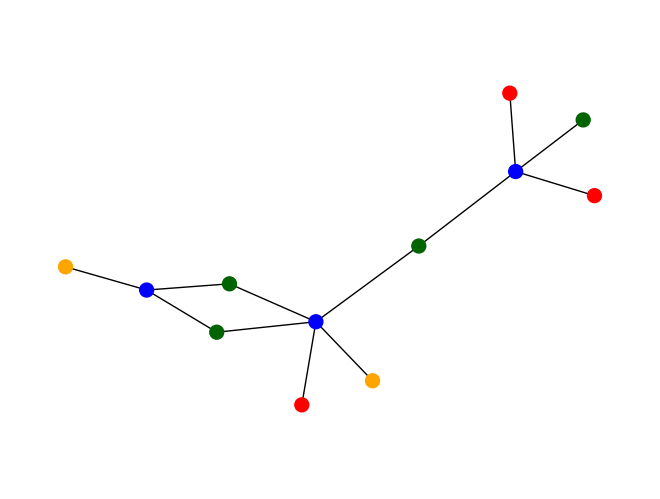

In [38]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [39]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['author'].numpy()[ind]
Counter(list0)

Counter({0.0: 50})

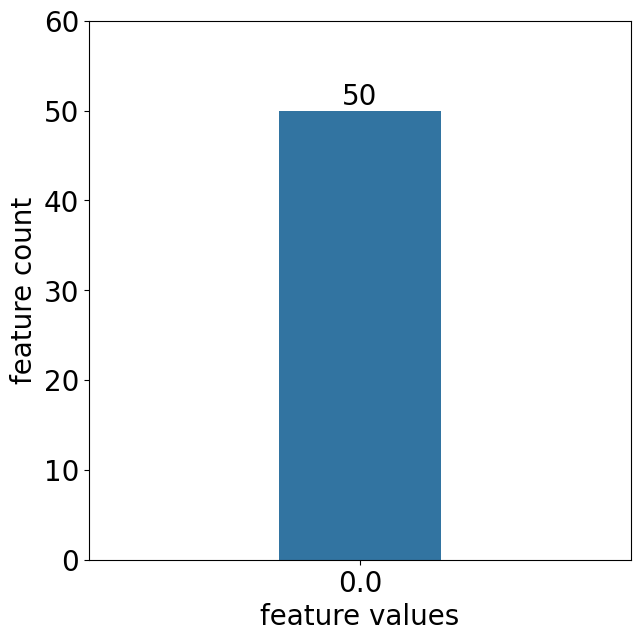

In [40]:
count_plot(list0)

Number of nodes:  9
graph id:  sync580879211114_G12
Max pred probability for class 1 is 0.598174512386322


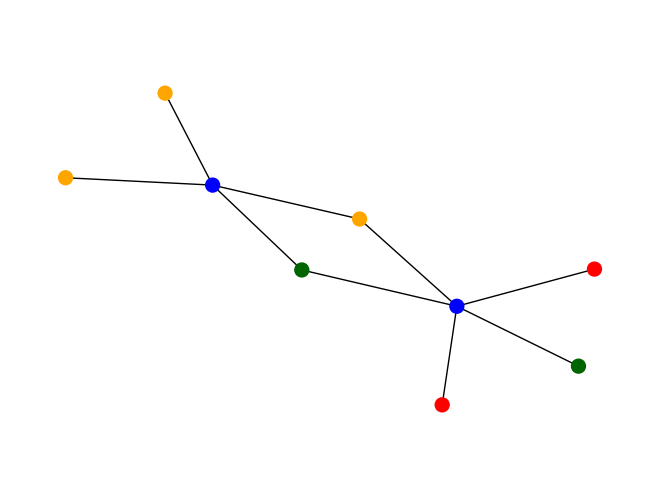

In [41]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [42]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['author'].numpy()[ind]
Counter(list1)

Counter({0.0: 50})

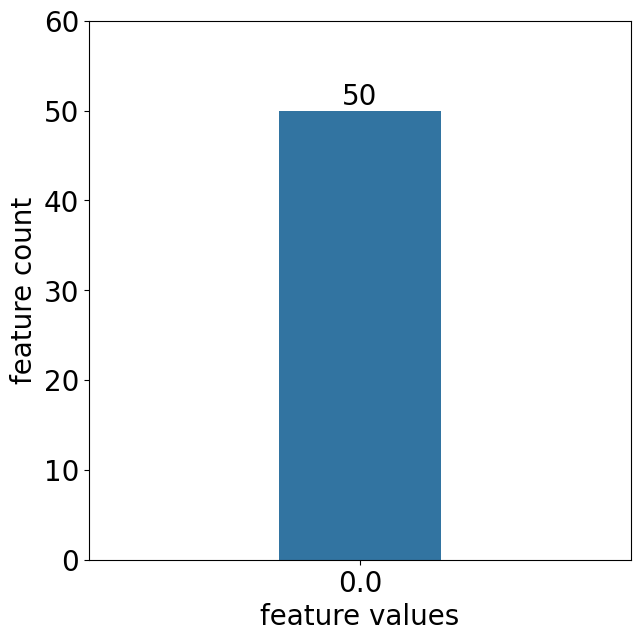

In [43]:
count_plot(list1)

Number of nodes:  14
graph id:  sync386125211226_G14
Max pred probability for class 2 is 0.9964660406112671


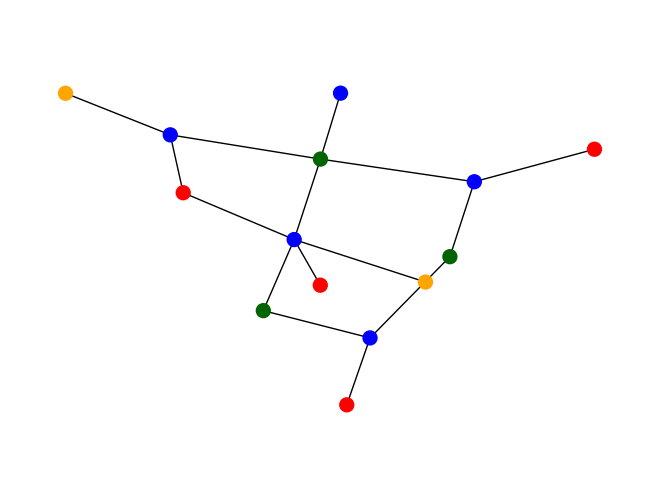

In [44]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [45]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['author'].numpy()[ind]
Counter(list2)

Counter({0.0: 50})

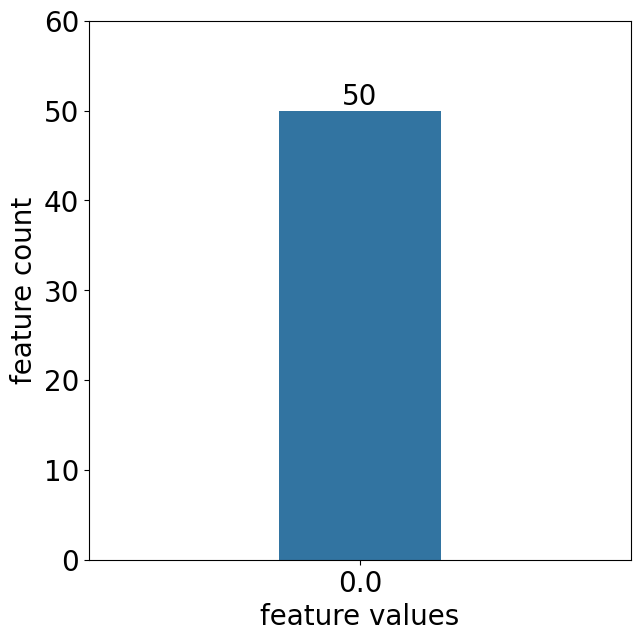

In [46]:
count_plot(list2)

Number of nodes:  12
graph id:  sync40459211211_G13
Max pred probability for class 3 is 0.39020174741744995


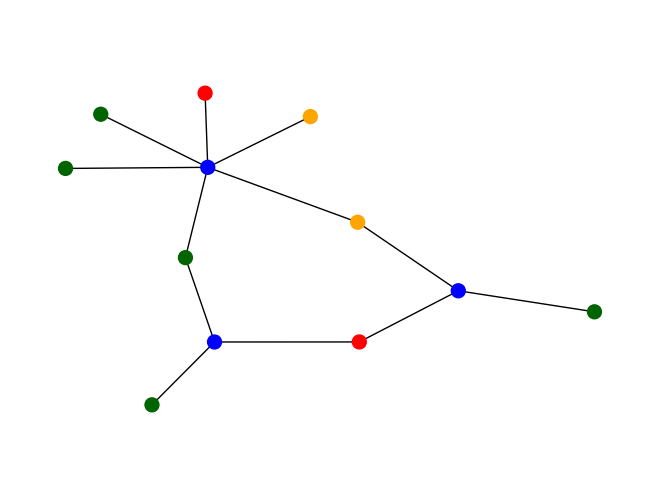

In [47]:
explanation_graph3 = plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

In [48]:
ind= index_2d(softmax_dict[class3_graphid], max_pred3)[0]
list3= nodefeature_dict[class3_graphid]['author'].numpy()[ind]
Counter(list3)

Counter({0.0: 50})

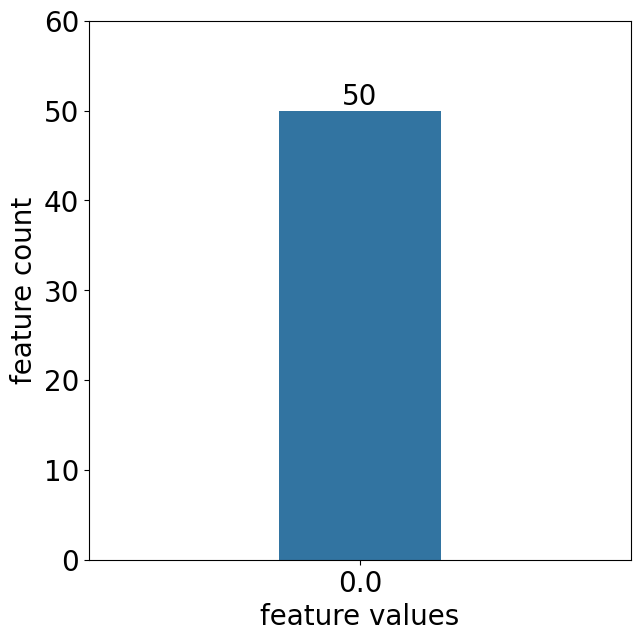

In [49]:
count_plot(list3)

In [50]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [51]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show()  

In [52]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat

In [53]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['term'].numpy())
print_stat_cont_features(term0_df)

mean 0.007247488
std dev 0.11566248


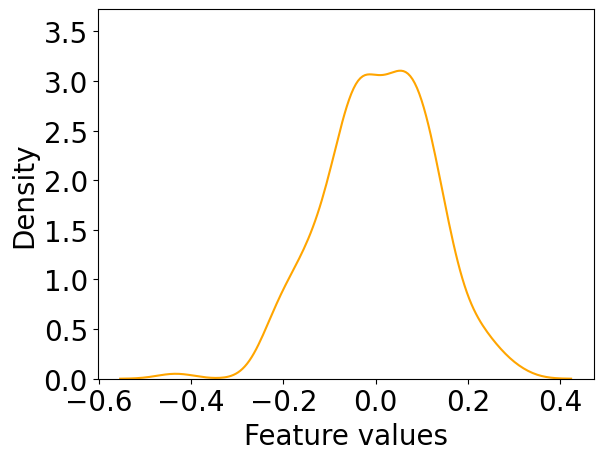

In [54]:
plot_node_feat(term0_df)

In [55]:
term1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['term'].numpy())
print_stat_cont_features(term1_df)

mean -0.0010737967
std dev 0.1471454


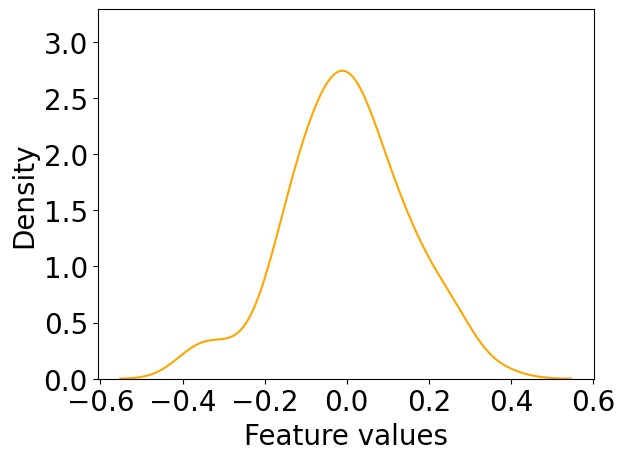

In [56]:
plot_node_feat(term1_df)

In [57]:
term2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['term'].numpy())
print_stat_cont_features(term2_df)

mean -0.0057854727
std dev 0.13237983


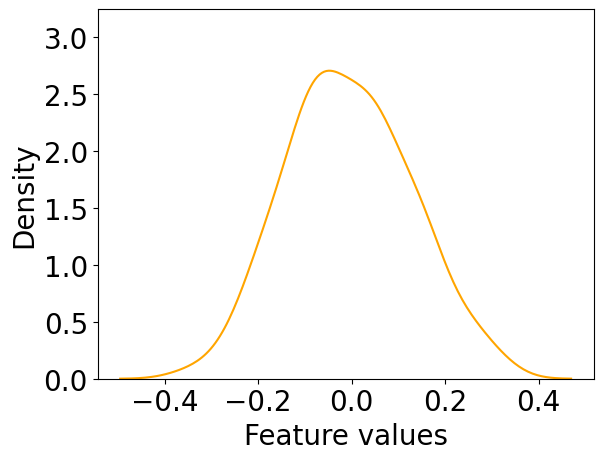

In [58]:
plot_node_feat(term2_df)

In [59]:
term3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['term'].numpy())
print_stat_cont_features(term3_df)

mean 0.010718769
std dev 0.13823962


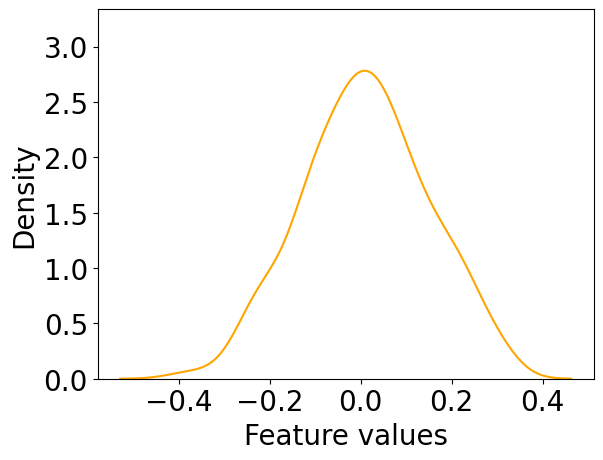

In [60]:
plot_node_feat(term3_df)

In [61]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['paper'].numpy())

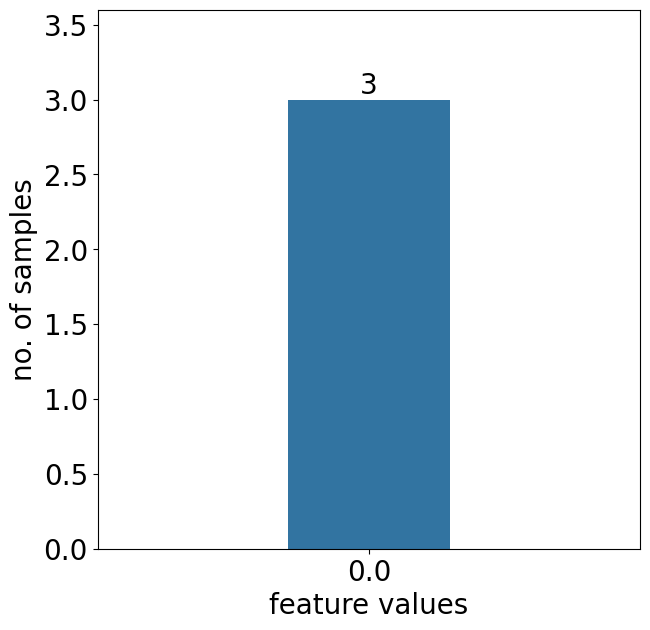

In [62]:
imp_paper_feat0=feature_selection(paper0_df)
plot_imp_feature(imp_paper_feat0.values.tolist())

In [63]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['paper'].numpy())

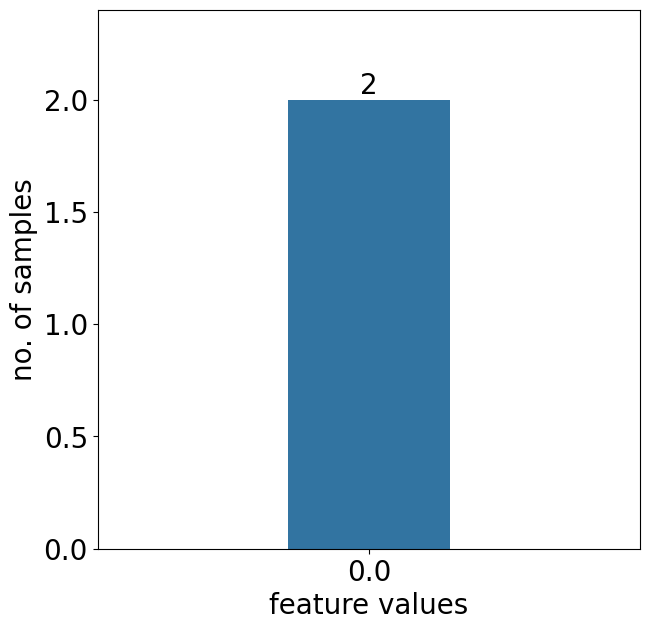

In [64]:
imp_paper_feat1=feature_selection(paper1_df)
plot_imp_feature(imp_paper_feat1.values.tolist())

In [65]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['paper'].numpy())

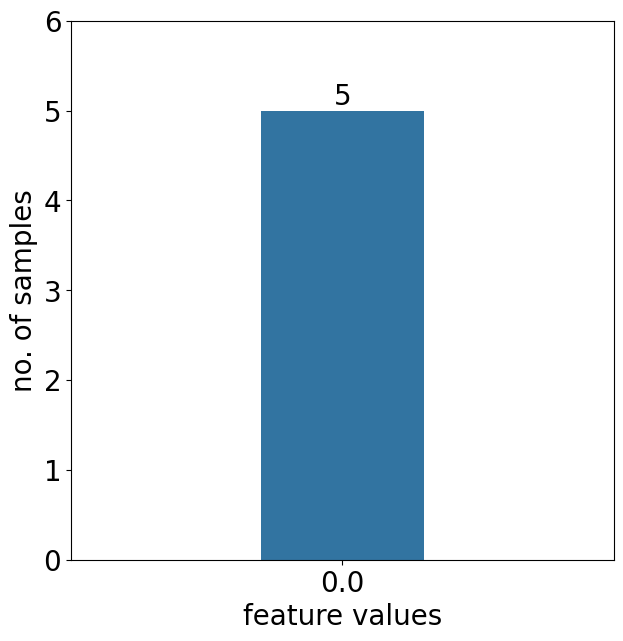

In [66]:
imp_paper_feat2=feature_selection(paper2_df)
plot_imp_feature(imp_paper_feat2.values.tolist())

In [67]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['paper'].numpy())

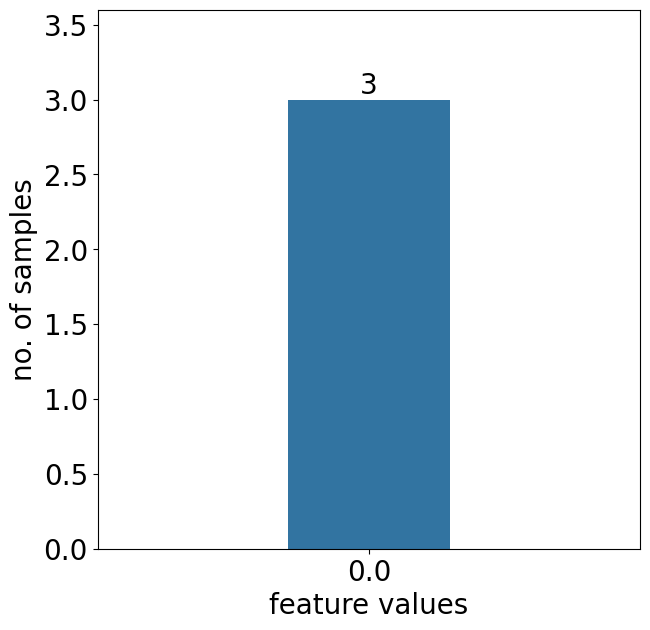

In [68]:
imp_paper_feat3=feature_selection(paper3_df)
plot_imp_feature(imp_paper_feat3.values.tolist())

In [4]:
motifs_path = '../../../../../common_motifs/dblp_10to15/'
files_motif = os.listdir(motifs_path)

In [5]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

../../../../../common_motifs/dblp_10to15/motif_real_10_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_13_0.gexf
../../..

In [74]:
def get_faithfulness(graphid_list):
    class_faithfulness = []
    for graphid in graphid_list:
        expln_graph = nx.Graph(all_edges[graphid])
        edges = all_edges_list[i][graphid]
        expln_graph = nx.Graph(edges)

        fid_score_list = []       
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)

            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            fid_score_list.append(x)

        class_faithfulness.append(np.mean(fid_score_list))

    return np.mean(class_faithfulness)

In [75]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graphid_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.6166666666666667
Run1 0.6833333333333333
Run2 0.6583333333333333
Run3 0.6833333333333333
Run4 0.5666666666666667
Run5 0.6833333333333333
Run6 0.5
Run7 0.4166666666666667
Run8 0.6833333333333333
Run9 0.6333333333333333
Mean 0.6125


In [76]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.08702250666733674
